In [4]:
import tensorflow as tf
import numpy as np 
from PIL import Image
import time
from datetime import datetime

import vgg19.vgg as vgg

In [7]:
def load_image(path, shape=None):
    image = Image.open(path)
    if shape is not None:
        shape = (shape[1], shape[2])
        image = image.resize(shape)
    img_array = np.asarray(image, dtype=np.float32) # np.float32(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array[:, :, :, 0] -= 103.939
    img_array[:, :, :, 1] -= 116.779
    img_array[:, :, :, 2] -= 123.68
    img_array = img_array[:, :, :, ::-1]
    
    print("Image loaded: ", path)
    return img_array

def save_image(path, x):
    image = np.copy(x)
    save_img = show_img(image)
    save_img.save(path)
    print("Image saved as: ", path)
    return save_img
    
def show_img(output):
    img_array = np.copy(output[0])
    img_array = img_array[:, :, ::-1]
    img_array[:, :, 0] += 103.939
    img_array[:, :, 1] += 116.779
    img_array[:, :, 2] += 123.68
    return Image.fromarray(np.clip(img_array, 0, 255).astype('uint8'))

def print_train():

    grad_dict = {model.image: gen_img}
    grad_dict.update({model.styl_activity[ln]:styl_activity_calc[ln] for ln in styl_layers})
    grad_dict.update({model.cont_activity[ln]:cont_activity_calc[ln] for ln in cont_layers})
    total_loss = sess.run(model.total_loss, feed_dict=grad_dict) #{model.image: gen_img, model.styl_img: styl_img, model.cont_img: cont_img})
    styl_loss = sess.run(model.styl_loss, feed_dict=grad_dict) #{model.image: gen_img})
    cont_loss = sess.run(model.cont_loss, feed_dict=grad_dict) #{model.image: gen_img})
    print("{} / {}".format(step, num_steps))
    print("styl_loss:", styl_loss)
    print("cont_loss:", cont_loss)
    print("total_loss:", total_loss)
    print("\n\n")

In [8]:
class Style_Transfer():
    
    def __init__(self, gen_img, img_shape, cont_layers, styl_layers, styl_layer_weights):
        self.gen_img = gen_img
        self.img_shape = img_shape
        self.gen_layers = cont_layers + styl_layers
        self.cont_layers = cont_layers
        self.styl_layers = styl_layers
        self.styl_layer_weights = styl_layer_weights
        
        self.graph = self.build_graph()
        
    def grammian(self, features):
        #input: features is a tensor of shape (1, Height, Width, Channels)

        features_shape = tf.shape(features)
        H = features_shape[1]
        W = features_shape[2]
        C = features_shape[3]

        matrix = tf.reshape(features, shape=[-1, C])
        gram = tf.matmul(matrix, matrix, transpose_a = True)
        return gram

    def compute_cont_loss(self):
        layer_cont_losses = {}
        
        # compute loss for each layer
        for layer in self.cont_layers: 
            layer_cont_losses[layer] = tf.losses.mean_squared_error(self.gen_cont_activity[layer],self.cont_activity[layer])
        cont_loss = tf.reduce_sum(list(layer_cont_losses.values()))
        
        return cont_loss
    
    def compute_styl_loss(self):
        layer_styl_losses = {}
        
        # compute grammian for each layer
        for layer_name in self.styl_layers:
            channels = self.gen_styl_activity[layer_name].get_shape().as_list()[3]
            feature_map_size = self.img_shape[1] * self.img_shape[2]
            denom = 2 * (channels ** 2) * (feature_map_size ** 2)
            layer_styl_losses[layer_name] = (1 / denom) * tf.losses.mean_squared_error(self.grammian(self.gen_styl_activity[layer_name]), self.grammian(self.styl_activity[layer_name]))
        
        total_styl_loss = tf.reduce_sum([self.styl_layer_weights[layer_name] * layer_styl_losses[layer_name] for layer_name in self.styl_layers])
        return total_styl_loss

In [9]:
class Style_Transfer(Style_Transfer):

    def build_graph(self):
        with tf.Graph().as_default() as g:
            
            with tf.variable_scope("image_input") as scope:
                self.image = tf.Variable(self.gen_img, trainable=True, dtype=tf.float32) 
                self.styl_img = tf.placeholder(tf.float32, shape=[1, None, None, None], name="style_image")
                self.cont_img = tf.placeholder(tf.float32, shape=[1, None, None, None], name="content_image")

            with tf.name_scope("vgg_model") as scope:
                self.vgg_net = vgg.Vgg19()

            with tf.name_scope("gen_activity") as scope:
                gen_model = self.vgg_net.build(self.image)
                self.gen_layer_ops = gen_model.layer_dict()
                self.gen_cont_activity = {layer_name: self.gen_layer_ops[layer_name] for layer_name in self.cont_layers}
                #self.gen_layer_ops[layer_name]
                self.gen_styl_activity = {layer_name: self.gen_layer_ops[layer_name] for layer_name in self.styl_layers}

            with tf.name_scope("styl_activity") as scope:
                styl_model = self.vgg_net.build(self.styl_img)
                self.styl_layer_ops = styl_model.layer_dict(self.styl_layers)
                self.styl_activity_calc = {layer_name: self.styl_layer_ops[layer_name] for layer_name in self.styl_layers}
        
                self.styl_activity = {layer_name: tf.placeholder(tf.float32, shape=[1, None, None, None], name="styl_activity")for layer_name in self.styl_layers}
                
            with tf.name_scope("cont_activity") as scope:
                cont_model = self.vgg_net.build(self.cont_img)
                self.cont_layer_ops = cont_model.layer_dict(self.cont_layers)
                self.cont_activity_calc = {layer_name: self.cont_layer_ops[layer_name] for layer_name in self.cont_layers}
                self.cont_activity = {layer_name: tf.placeholder(tf.float32, shape=[1, None, None, None]) for layer_name in self.cont_layers}
                
            with tf.variable_scope("styl_loss") as scope:
                self.styl_loss = styl_loss_alpha * self.compute_styl_loss()
                
            with tf.variable_scope("cont_loss") as scope:
                self.cont_loss = cont_loss_beta * self.compute_cont_loss()
                
            with tf.variable_scope("total_loss") as scope:
                self.total_loss = self.styl_loss + self.cont_loss #tf.Variable(self.styl_loss + self.cont_loss)

            with tf.name_scope("train") as scope:
                self.beta1 = tf.Variable(0.9)
                self.beta2 = tf.Variable(0.999)
                self.episilon = tf.Variable(1)
                self.train_ops = tf.train.AdamOptimizer(learning_rate).minimize(self.total_loss,var_list=self.image)
                
            with tf.name_scope("init") as scope:
                self.init_op = tf.global_variables_initializer()
            
        return g
    

In [10]:
print(datetime.now(), "Loading all hyperparameters. ")

# initalize content and style layers
cont_layers = ["conv4_2"]
styl_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
gen_layers = cont_layers + styl_layers

# weights on each layer
styl_layer_weights = {"conv1_1": 0.2, "conv1_2": 0, "pool1": 0, 
                      "conv2_1": 0.2, "conv2_2": 0, "pool2": 0,
                      "conv3_1": 0.2, "conv3_2": 0, "conv3_3": 0, "conv3_4":0, "pool3": 0, 
                      "conv4_1": 0.2, "conv4_2": 0, "conv4_3":0, "conv4_4": 0, "pool4": 0,
                      "conv5_1":0.2, "conv5_2": 0, "conv5_3": 0, "conv5_4": 0, "pool5": 0}

# hyper-parameters
img_shape = np.array([1, 100, 100, 3]) # [batch, height, width, channels]
styl_loss_alpha, cont_loss_beta = 50, 0.5 # alpha/beta = 1e-3 or 1e-4
learning_rate = 10
num_steps = 100 # training iterations

2018-06-17 00:13:52.724154 Loading all hyperparameters. 


In [11]:
# load image
styl_img_file = 'style/starry_night.jpg'
cont_img_file = 'content/tubingen.jpg'
white_img_file = 'white_noise/plain_white.jpg'
gen_img_file = 'gen_img.jpeg'

# turn image into numpy arrays
print(datetime.now(), "Loading images")
styl_img = load_image(styl_img_file, shape=img_shape) 
cont_img = load_image(cont_img_file, shape=img_shape) 
gen_img = load_image(white_img_file, shape=img_shape)

2018-06-17 00:13:52.734246 Loading images
Image loaded:  style/starry_night.jpg
Image loaded:  content/tubingen.jpg
Image loaded:  white_noise/plain_white.jpg


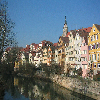

In [7]:
show_img(cont_img)

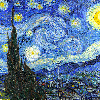

In [8]:
show_img(styl_img)

In [9]:
# initialize Sytle_Transfer Model
print(datetime.now(), "Initializing Style Transfer Model")
time_model_start = time.time()
model = Style_Transfer(gen_img, img_shape, cont_layers, styl_layers, styl_layer_weights)
time_model_end = time.time()
print("Time taken: ", time_model_end - time_model_start)

2018-06-15 08:07:28.998164 Initializing Style Transfer Model
Time taken:  2.2803688049316406


In [10]:
with tf.Session(graph=model.graph) as sess:
    
    # initialize variables
    sess.run(model.init_op, feed_dict={model.cont_img:cont_img, model.styl_img:styl_img})
    print("variables initialized ")
    
    # style and content activities 
    styl_activity_calc = sess.run(model.styl_activity_calc, feed_dict={model.styl_img: styl_img})
    cont_activity_calc = sess.run(model.cont_activity_calc, feed_dict={model.cont_img: cont_img})
    print("Begin Training.")
    prev_loss = 0
    time_train_start = time.time()
    for step in range(num_steps):
        grad_dict = {}
        grad_dict.update({model.styl_activity[ln]:styl_activity_calc[ln] for ln in styl_layers})
        grad_dict.update({model.cont_activity[ln]:cont_activity_calc[ln] for ln in cont_layers})
        _, total_loss, cont_loss, styl_loss = sess.run([model.train_ops, model.total_loss, model.cont_loss, model.styl_loss], feed_dict=grad_dict)#), grad_dict)
        
        if step % 10 == 0:
            result = sess.run(model.image, feed_dict={})
            print("Step: ", step)
            print("cont_loss:", cont_loss)
            print("styl_loss:", styl_loss)
            print("total_loss:", total_loss)
            
            save_image("./step_log/" + str(step) + ".jpg", result)
    time_train_end = time.time()
    print("Training Completed.")
    print("Training time required: ", time_model_end - time_model_start)
    
    save_image(gen_img_file, result)
    tf.summary.FileWriter("./log", model.graph)

variables initialized 
Begin Training.
Step:  0
cont_loss: 3654.96
styl_loss: 32152.4
total_loss: 35807.4
Image saved as:  ./step_log/0.jpg
Step:  10
cont_loss: 2735.77
styl_loss: 26100.3
total_loss: 28836.1
Image saved as:  ./step_log/10.jpg
Step:  20
cont_loss: 1680.52
styl_loss: 21570.5
total_loss: 23251.0
Image saved as:  ./step_log/20.jpg
Step:  30
cont_loss: 1313.94
styl_loss: 17875.6
total_loss: 19189.5
Image saved as:  ./step_log/30.jpg
Step:  40
cont_loss: 1177.92
styl_loss: 14876.6
total_loss: 16054.5
Image saved as:  ./step_log/40.jpg
Step:  50
cont_loss: 1087.03
styl_loss: 12445.3
total_loss: 13532.3
Image saved as:  ./step_log/50.jpg
Step:  60
cont_loss: 1034.25
styl_loss: 10433.6
total_loss: 11467.8
Image saved as:  ./step_log/60.jpg
Step:  70
cont_loss: 993.765
styl_loss: 8763.91
total_loss: 9757.67
Image saved as:  ./step_log/70.jpg
Step:  80
cont_loss: 961.142
styl_loss: 7395.79
total_loss: 8356.94
Image saved as:  ./step_log/80.jpg
Step:  90
cont_loss: 930.373
styl_lo

Image saved as:  gen_img.jpeg


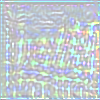

In [17]:
from PIL import Image
min(Image.open(cont_img_file).size, Image.open(styl_img_file).size)

(1024, 768)

In [19]:
Image.open(styl_img_file).resize(Image.open(cont_img_file).size).size

(1024, 768)

In [9]:
Image.open("content/f1_car.jpg").size
Image.open("gen_img/gen_img.jpeg").size

(932, 932)